In [17]:
# %load classify_embs.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import time
from svector import svector
from gensim.models import KeyedVectors
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.svm import LinearSVC




#trainfile = sys.argv[1]
#devfile = sys.argv[2]
#testfile = sys.argv[3]

trainfile = "train.txt"
devfile = "dev.txt"
testfile = "test.txt"

output = {}

# load the embeddings
wv = KeyedVectors.load('embs_train.kv')



#####   Perceptron

def read_from(textfile):
    for line in open(textfile):
        label, words = line.strip().split("\t")
        yield (1 if label=="+" else -1, words.split())


def preprocess(file):
    x_out = []
    y_out = []

    for i, (label, words) in enumerate(parse_from(file), 1):
        x_out.append(words)
        y_out.append(label)

    return (x_out, y_out)


def make_vector(words):
    v = svector()
    v['im_bias'] = 1.0
    #v['im_bias'] = np.ones(wv.vector_size)     # add a bias feature, set it to 1, we now have d+1 dim
    word_embeddings = [wv[word] for word in words if word in wv]
    sentence_embedding = np.mean(word_embeddings, axis=0)
    #v[" ".join(words)] = sentence_embedding
    for word in words:
        v[word] = np.linalg.norm(sentence_embedding)
        #v[word] = sentence_embedding
    return v


def test(devfile, model, dev_errs):
    tot, err = 0, 0
    for i, (label, words) in enumerate(read_from(devfile), 1): # note 1...|D|
        sent = make_vector(words)
        err += label * (model.dot(sent)) <= 0
        # get max/min errors on dev
        dev_errs.append((label, label * (model.dot(make_vector(words))), words))
    return err/i  # i is |D| now



def train(trainfile, devfile, epochs=5):
    t = time.time()
    best_err = 1.
    model = svector()
    model['im_bias'] = 0.0    
    #model['im_bias'] = np.zeros(wv.vector_size)   
    for it in range(1, epochs+1):
        updates = 0
        for i, (label, words) in enumerate(read_from(trainfile), 1): # label is +1 or -1
            sent = make_vector(words)
            if label * (model.dot(sent)) <= 0:
                updates += 1
                model += label * sent 
        dev_errs = []
        dev_err = test(devfile, model, dev_errs)
        best_err = min(best_err, dev_err)
        #print("epoch %d, update %.1f%%, dev %.1f%%" % (it, updates / i * 100, dev_err * 100))
    #print("Naive Perceptron Dev Error %.1f%%, |w|=%d, time: %.1f secs" % (best_err * 100, len(model), time.time() - t))
    return model



def train_avg(trainfile, devfile, epochs=5):
    t = time.time()
    best_err = 1.
    model = svector()
    model['im_bias'] = 0.0
    #model['im_bias'] = np.zeros(wv.vector_size)    
    w_aux = svector()
    count = 0
    for it in range(1, epochs+1):
        updates = 0
        for i, (label, words) in enumerate(read_from(trainfile), 1): # label is +1 or -1
            sent = make_vector(words)
            if label * (model.dot(sent)) <= 0:  # model made a mistake
                updates += 1
                model += label * sent
                w_aux += count * label * sent
            count += 1 
        dev_errs = []
        dev_err = test(devfile, (count * model) - w_aux, dev_errs)
        best_err = min(best_err, dev_err)



        #print("epoch %d, update %.1f%%, dev %.1f%%" % (it, updates / i * 100, dev_err * 100))
    #print("Avg Perceptron Dev Error: %.1f%%, |w|: %d, time: %.1f secs" % (best_err * 100, len(model), time.time() - t))
    output["avg"] = [best_err*100, 0]
    return model



# predict on test data
def predict(testfile, model): 
    y_test_pred = []
    t = time.time()
    for i, (label, words) in enumerate(read_from(testfile), 1):
        pred = (model.dot(make_vector(words)))
        y_test_pred.append(1 if pred > 0 else -1)
    y_test_tot = sum( [1 for label in y_test_pred if label == 1] )
    #print(f"% Pos on Test data: {100*y_test_tot/1000:.1f}%")
    output["avg"][1] = 100*y_test_tot/1000



#####     Embeddings

def parse_from(textfile):
    for line in open(textfile):
        label, words = line.strip().split("\t")
        yield (1 if label=="+" else -1, words)


# process the embeddings
def wv_process(file):
    x_out = []
    y_out = []

    for i, (label, words) in enumerate(parse_from(file), 1):
        # get word embeddings for this sentence
        words = words.lower().split()
        word_embeddings = [wv[word] for word in words if word in wv]
        if len(word_embeddings) > 0:
            # take the mean of the wv's for this sentence
            sentence_embedding = np.mean(word_embeddings, axis=0)
            x_out.append(sentence_embedding)
        else:
            # if none of the words were in wv, generate a zero-vector
            empty_sentence = np.zeros(wv.vector_size)
            x_out.append(empty_sentence.tolist())
        y_out.append(label)

    return (x_out, y_out)


## pre-process the data for word embeddings for dense vectors
x_train, y_train = wv_process(trainfile)
x_dev, y_dev = wv_process(devfile)
x_test, y_test = wv_process(testfile)


## scale the word-embeddings data
#scaler = MinMaxScaler()
#x_train = scaler.fit_transform(x_train)
#x_dev = scaler.transform(x_dev)
#x_test = scaler.transform(x_test)


model_avg = train_avg(trainfile, devfile, 10)
predict(testfile, model_avg)


tron = Perceptron()
t_tron = time.time()
tron.fit(x_train, y_train)
y_dev_pred = tron.predict(x_dev)
tron_acc = accuracy_score(y_dev, y_dev_pred)    # calc the best DEV accuracy
#print(f"Sklearn Perceptron Dev Error: {100-100*tron_acc:.1f}%, time: {(time.time() - t_tron):.1f} secs")
output["sklp"] = [100-100*tron_acc, 0]

y_test_pred = tron.predict(x_test)
y_test_tot = sum( [1 for label in y_test_pred if label == 1] )
#print(f"Sklearn Perceptron % Pos on Test data: {100*y_test_tot/1000:.1f}%")
#print()
output["sklp"][1] = 100*y_test_tot/1000



reg = LinearSVC()
t_reg = time.time()
reg.fit(x_train, y_train)
y_dev_pred = reg.predict(x_dev)
reg_acc = accuracy_score(y_dev, y_dev_pred)
#print(f"LSVC Classifier Dev Error: {100-100*reg_acc:.1f}%, time: {(time.time() - t_reg):.1f} secs")
output["lsvc"] = [100-100*reg_acc, 0]

y_test_pred = reg.predict(x_test)
y_test_tot = sum( [1 for label in y_test_pred if label == 1] )
#print(f"LSVC % Pos on Test data: {100*y_test_tot/1000:.1f}%")
#print()
output["lsvc"][1] = 100*y_test_tot/1000


# run an SVM classifier
svc = SVC(kernel='linear')
t_svc = time.time()
svc.fit(x_train, y_train)
y_dev_pred = svc.predict(x_dev)
svc_acc = accuracy_score(y_dev, y_dev_pred)
#print(f"SVC Classifier Dev Error: {100-100*svc_acc:.1f}%, time: {(time.time() - t_svc):.1f} secs")
output["svc"] = [100-100*svc_acc, 0]

y_test_pred = svc.predict(x_test)
y_test_tot = sum( [1 for label in y_test_pred if label == 1] )
#print(f"SVC % Pos on Test data: {100*y_test_tot/1000:.1f}%")
#print()
output["svc"][1] = 100*y_test_tot/1000


# run an MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(1000,), activation='identity', solver='adam', 
                    alpha=0.0001, batch_size='auto', learning_rate='constant', 
                    learning_rate_init=0.001, max_iter=1000, random_state=42)
t_mlp = time.time()
mlp.fit(x_train, y_train)
y_dev_pred = mlp.predict(x_dev)
mlp_acc = accuracy_score(y_dev, y_dev_pred)
#print(f"MLP Classifier Dev Error: {100-100*mlp_acc:.1f}%, time: {(time.time() - t_mlp):.1f} secs")
output["mlp"] = [100-100*mlp_acc, 0]

y_test_pred = mlp.predict(x_test)
y_test_tot = sum( [1 for label in y_test_pred if label == 1] )
#print(f"MLP % Pos on Test data: {100*y_test_tot/1000:.1f}%")
#print()
output["mlp"][1] = 100*y_test_tot/1000


#for k,v in output.items():
#    print(f"{k},{v[0]:.1f},{v[1]:.1f}")





/Users/jojo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/jojo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/jojo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


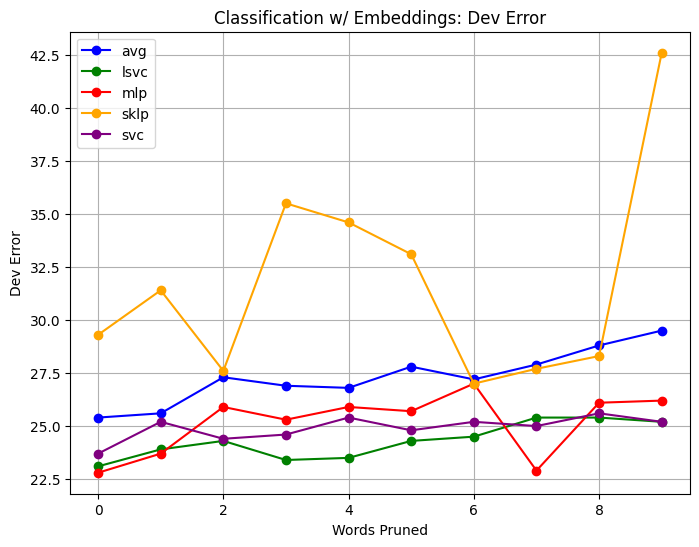

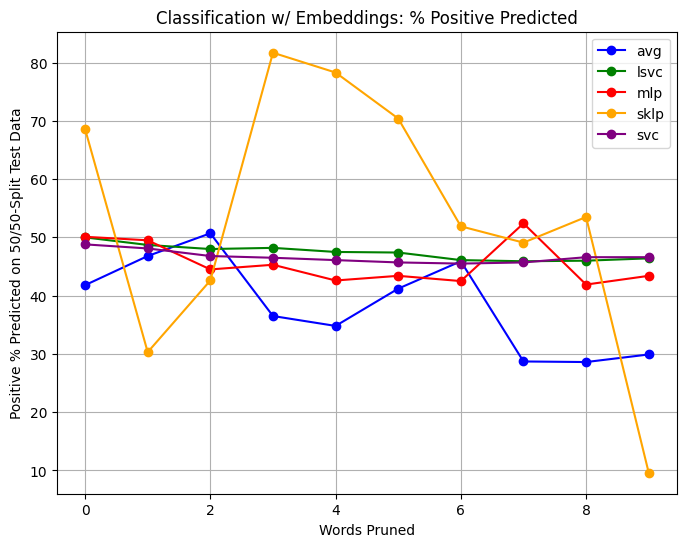

In [19]:
## after running tasks-graph.sh
## use resulting csv file "graph.csv" to plot classification results

df = pd.read_csv('graph-embs.csv', names=["classifier","dev","pos","prune"])

classifier = df['classifier']
dev_err = df['dev']
percent_pos = df['pos']
words_pruned = df['prune']


# group each of the classifiers by classifier name
grouped = df.groupby('classifier')


# Create a figure and axis for Dev_Error plots
fig1, ax1 = plt.subplots(figsize=(8, 6))

# Define colors and markers for each group
colors = ['blue', 'green', 'red', 'orange', 'purple']

# Iterate through groups and plot lines for each group
for i, (label, group) in enumerate(grouped):
    ax1.plot(group['prune'], group['dev'], label=label, color=colors[i], marker='o', linestyle='-')

# Set labels and title
ax1.set_xlabel('Words Pruned')
ax1.set_ylabel('Dev Error')
ax1.set_title('Classification w/ Embeddings: Dev Error')

# Show legend
ax1.legend()

# Show the plot
plt.grid(True)
plt.show()






# Create another figure and axis for Percent_Pos plots
fig2, ax2 = plt.subplots(figsize=(8, 6))

# Define colors and markers for each group
colors = ['blue', 'green', 'red', 'orange', 'purple']

# Iterate through groups and plot lines for each group
for i, (label, group) in enumerate(grouped):
    ax2.plot(group['prune'], group['pos'], label=label, color=colors[i], marker='o', linestyle='-')

# Set labels and title
ax2.set_xlabel('Words Pruned')
ax2.set_ylabel('Positive % Predicted on 50/50-Split Test Data')
ax2.set_title('Classification w/ Embeddings: % Positive Predicted')

# Show legend
ax2.legend()

# Show the plot
plt.grid(True)
plt.show()